<center>
    <font size="6"><b>Bid and Ask Reconstruction</b></font>
    <br>
    <font size="3">(draft version)</font>
</center>

<br>

<center>
    <font size="3"><b>Piotr Lipiński</b></font>
    <br>
    Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
    <br>
    lipinski@cs.uni.wroc.pl
</center>

### Abstract:

This notebook defines the assignment on reconstructing bid and ask data from transaction data.

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as linMod
import sklearn.cluster as clu

%matplotlib inline

## Input data

In the stock market with the order driven trading mechanism, when a trader submits a buy (or sell) order to the stock market, his order is matched with other registered orders and if there is an opposite order - someone declares to sell (or buy) the required number of stocks at the required price - the transaction is executed, otherwise his order is registered in the order book and waits for new incoming orders. Bid is the price of the best buy order registered in the order book and ask is the price of the best sell order registered in the order book. Assuming some simplification, transaction prices should be usually equal either to bid or to ask (in practice, some large orders are splitted and matched partially to a number of opposite orders, so the final price may differ from bid and ask).

Input data contains the transaction data as well as the bid and ask data for a selected stock from the London Stock Exchange over a selected period.

In [188]:
df_bid_ask = pd.read_csv('Dane/bid_ask.csv', index_col='timestamp', parse_dates=['timestamp'])
display(df_bid_ask)

bid     ask
timestamp                          
2013-09-02 08:30:00  2994.5  2995.5
2013-09-02 08:31:00  2997.0  2998.0
2013-09-02 08:32:00  2996.5  2998.0
2013-09-02 08:33:00  2996.0  2998.0
2013-09-02 08:34:00  2997.0  2998.5
...                     ...     ...
2013-09-13 15:56:00  3118.5  3119.0
2013-09-13 15:57:00  3119.0  3119.5
2013-09-13 15:58:00  3122.0  3122.5
2013-09-13 15:59:00  3122.5  3123.5
2013-09-13 16:00:00  3123.5  3124.0

[4510 rows x 2 columns]

In [189]:
df_transaction = pd.read_csv('Dane/transaction.csv', index_col='timestamp', parse_dates=['timestamp'])
display(df_transaction)

transaction
timestamp                       
2013-09-02 08:32:00       2998.0
2013-09-02 08:33:00       2998.0
2013-09-02 08:34:00       2998.5
2013-09-02 08:35:00       2999.0
2013-09-02 08:38:00       3020.0
...                          ...
2013-09-13 15:54:00       3119.0
2013-09-13 15:55:00       3118.5
2013-09-13 15:56:00       3118.5
2013-09-13 15:57:00       3119.0
2013-09-13 16:00:00       3123.5

[2221 rows x 1 columns]

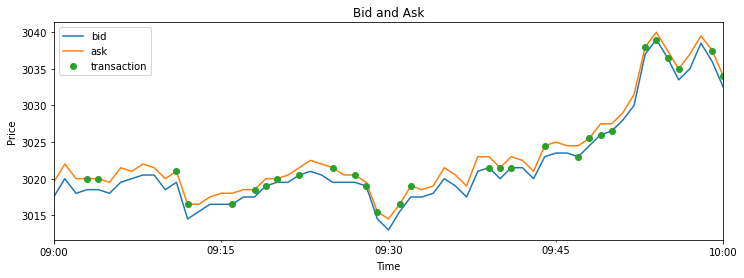

In [190]:
plt.figure(figsize=(12, 4))
df_bid_ask['bid']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='bid')
df_bid_ask['ask']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='ask')
df_transaction['transaction']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask')
plt.legend(loc='upper left')
plt.show()

## Assignment

Please propose an approach to reconstruct bid and ask data from transaction data. Select one or more time periods for training the approach. In training, you may use the transaction data as well as the bid and ask data. Select one or more time periods for testing the approach. In testing, your approach should use only the transaction data.

In [191]:
def bladBezwzglednyPrzewidywanTylkoNaTrans(orginalne_bid_ask, przewidziane_bid_ask):
    bid_err=np.sum(np.abs(orginalne_bid_ask["bid"]-przewidziane_bid_ask["bid"]))
    ask_err=np.sum(np.abs(orginalne_bid_ask["ask"]-przewidziane_bid_ask["ask"]))
    return (bid_err, ask_err)

In [192]:
def bladBezwzglednyPrzewidywan(orginalne_bid_ask, przewidziane_bid_ask):
    df_merged=pd.merge_asof(orginalne_bid_ask, przewidziane_bid_ask, 
                            left_on="timestamp", right_index=True, suffixes=("_org","_rek"),direction="nearest")
    bid_err=np.sum(np.abs(df_merged["bid_org"]-df_merged["bid_rek"]))
    ask_err=np.sum(np.abs(df_merged["ask_org"]-df_merged["ask_rek"]))
    return (bid_err, ask_err)

In [193]:
def bladKwadratowyPrzewidywan(orginalne_bid_ask, przewidziane_bid_ask):
    df_merged=pd.merge_asof(orginalne_bid_ask, przewidziane_bid_ask, 
                            left_on="timestamp", right_index=True, suffixes=("_org","_rek"),direction="nearest")
    bid_err=np.sum((df_merged["bid_org"]-df_merged["bid_rek"])**2)
    ask_err=np.sum((df_merged["ask_org"]-df_merged["ask_rek"])**2)
    return (bid_err, ask_err)

## Example

In [194]:
selection = df_transaction['2013-09-02 9:00':'2013-09-02 10:00'].index.values
df_bid_ask_cut=df_bid_ask['2013-09-02 9:00':'2013-09-02 10:00']
df_selected_trans=df_transaction['2013-09-02 9:00':'2013-09-02 10:00']

In [195]:
selection_test = df_transaction['2013-09-03 9:00':'2013-09-03 10:00'].index.values
df_bid_ask_cut_test=df_bid_ask['2013-09-03 9:00':'2013-09-03 10:00']
df_selected_trans_test=df_transaction['2013-09-03 9:00':'2013-09-03 10:00']

In [196]:
def simplePrediction(df_bid_ask_cut, df_transaction_cut, std):
    df_bid_ask_reconstructed = pd.DataFrame(np.zeros((len(df_transaction_cut), 2)), index=df_transaction_cut.index, columns=['bid', 'ask'])
    df_bid_ask_reconstructed['bid'] = df_transaction_cut['transaction'] - 0.1 * std
    df_bid_ask_reconstructed['ask'] = df_transaction_cut['transaction'] + 0.1 * std

    plt.figure(figsize=(12, 4))
    df_bid_ask_reconstructed['bid'].plot(label='bid reconstructed')
    df_bid_ask_reconstructed['ask'].plot(label='ask reconstructed')
    df_transaction_cut['transaction'].plot(label='transaction', style='o')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Bid and Ask')
    plt.legend(loc='upper left')
    plt.show()

    print(bladBezwzglednyPrzewidywanTylkoNaTrans(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladBezwzglednyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladKwadratowyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))

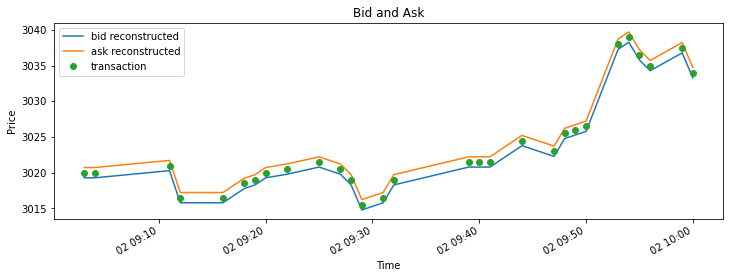

(19.40578084557319, 18.469594477968258)
(61.843468507343914, 60.90728213973898)
(131.6973516008458, 128.39179508636258)


In [197]:
simplePrediction(df_bid_ask_cut,df_selected_trans, df_selected_trans.loc[selection]['transaction'].std())

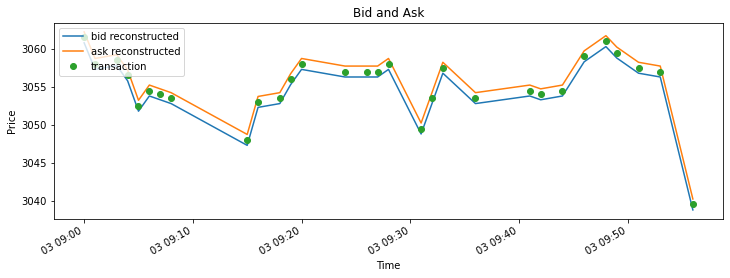

(22.937687661770724, 19.5)
(111.46959447796826, 108.90578084557319)
(622.1365405567822, 618.7953239906869)


In [198]:
simplePrediction(df_bid_ask_cut_test,df_selected_trans_test, df_selected_trans.loc[selection]['transaction'].std())

# Podejście 1

In [202]:
def klasyfikacjaNaPodstawieTrendu(df_bid_ask_cut, df_selected_trans, std):
    df_trend=df_selected_trans.rolling(5,1,win_type="exponential", center=True).mean(tau=0.5)

    df_bid_ask_reconstructed = pd.DataFrame(np.zeros((len(df_selected_trans), 2)), index=df_selected_trans.index, columns=['bid', 'ask'])
    df_bid_ask_reconstructed['bid'][0] = df_selected_trans['transaction'][0] - 0.1 * std
    df_bid_ask_reconstructed['ask'][0] = df_selected_trans['transaction'][0] + 0.1 * std
    for i in range(1,len(df_bid_ask_reconstructed)):
        if df_trend['transaction'][i]>df_selected_trans['transaction'][i]:
            df_bid_ask_reconstructed['bid'][i] = df_selected_trans['transaction'][i]
            df_bid_ask_reconstructed['ask'][i] = df_bid_ask_reconstructed['ask'][i-1]-\
                                                 df_bid_ask_reconstructed['bid'][i-1]+\
                                                 df_bid_ask_reconstructed['bid'][i]
        else:
            df_bid_ask_reconstructed['ask'][i] = df_selected_trans['transaction'][i]
            df_bid_ask_reconstructed['bid'][i] = df_bid_ask_reconstructed['bid'][i-1]-\
                                                 df_bid_ask_reconstructed['ask'][i-1]+\
                                                 df_bid_ask_reconstructed['ask'][i]

    plt.figure(figsize=(14, 5))
    df_bid_ask_reconstructed['bid'].plot(label='bid reconstructed')
    df_bid_ask_reconstructed['ask'].plot(label='ask reconstructed')
    df_bid_ask_cut['bid'].plot(label='bid original', color='#808080')
    df_bid_ask_cut['ask'].plot(label='ask original', color='#808080')
    df_selected_trans['transaction'].plot(label='transaction', style='o')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Bid and Ask')
    plt.legend()
    plt.show()
    
    print(bladBezwzglednyPrzewidywanTylkoNaTrans(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladBezwzglednyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladKwadratowyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))

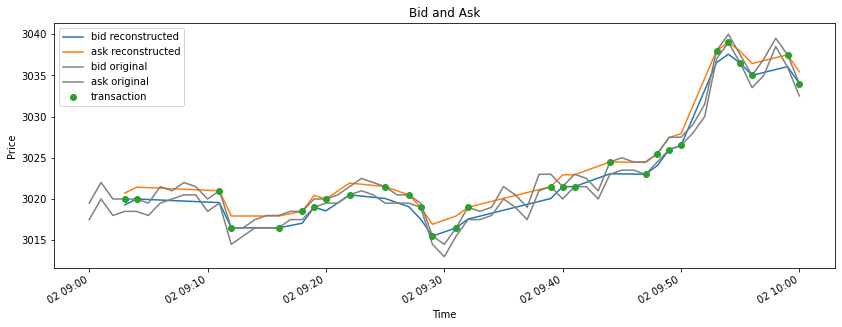

(18.59421915442681, 15.78265746328043)
(56.750750647082896, 54.06381363239507)
(121.92954781018018, 115.83820165200382)


In [203]:
klasyfikacjaNaPodstawieTrendu(df_bid_ask_cut,df_selected_trans, df_selected_trans.loc[selection]['transaction'].std())

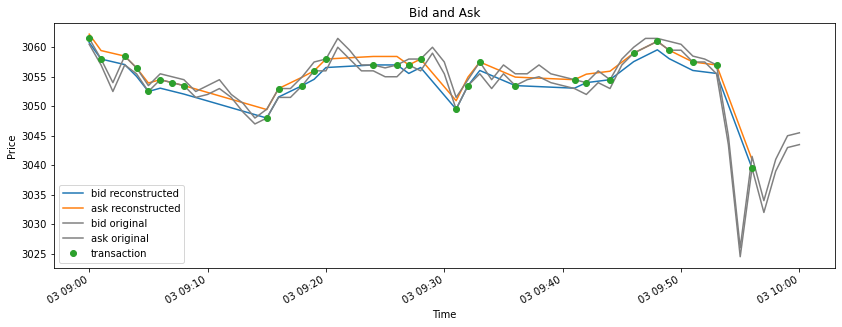

(23.09421915442681, 20.09421915442681)
(111.3449698015097, 107.90578084557319)
(627.8916079880629, 615.3845929801544)


In [204]:
klasyfikacjaNaPodstawieTrendu(df_bid_ask_cut_test,df_selected_trans_test, df_selected_trans.loc[selection]['transaction'].std())

# Podejście 2 - lokalne kMeans

In [205]:
def klasyfikacjaPrzezRuchomekMeans(df_bid_ask_cut, df_selected_trans, std):
    model=clu.KMeans(2)
    ask_klasa=np.zeros(len(df_selected_trans))
    for i in range(2,len(df_selected_trans)-1):
        klasy=model.fit_predict(df_selected_trans.values[i-2:i+3])
        if model.cluster_centers_[0,0] >model.cluster_centers_[1,0]:
            ask_klasa[i-2:i+3][klasy==0]+=1
            ask_klasa[i-2:i+3][klasy==1]-=1
        else:
            ask_klasa[i-2:i+3][klasy==0]-=1
            ask_klasa[i-2:i+3][klasy==1]+=1
            
    df_bid_ask_reconstructed = pd.DataFrame(np.zeros((len(df_selected_trans), 2)), index=df_selected_trans.index, columns=['bid', 'ask'])
    if ask_klasa[0]>0:
        df_bid_ask_reconstructed['bid'][0] = df_selected_trans['transaction'][0] - 0.1 * std
        df_bid_ask_reconstructed['ask'][0] = df_selected_trans['transaction'][0]
    else:
        df_bid_ask_reconstructed['bid'][0] = df_selected_trans['transaction'][0]
        df_bid_ask_reconstructed['ask'][0] = df_selected_trans['transaction'][0] + 0.1 * std 
    
    mnoznik=1
    for i in range(1,len(df_bid_ask_reconstructed)):
        if ask_klasa[i]<0:
            df_bid_ask_reconstructed['bid'][i] = df_selected_trans['transaction'][i]
            df_bid_ask_reconstructed['ask'][i] = (df_bid_ask_reconstructed['ask'][i-1]-\
                                                 df_bid_ask_reconstructed['bid'][i-1])*mnoznik+\
                                                 df_bid_ask_reconstructed['bid'][i]
        else:
            df_bid_ask_reconstructed['ask'][i] = df_selected_trans['transaction'][i]
            df_bid_ask_reconstructed['bid'][i] = (df_bid_ask_reconstructed['bid'][i-1]-\
                                                 df_bid_ask_reconstructed['ask'][i-1])*mnoznik+\
                                                 df_bid_ask_reconstructed['ask'][i]

#        if np.abs(ask_klasa[i])<=1:
 #           mnoznik*=0.75
  #      if np.abs(ask_klasa[i]>=4):
   #         mnoznik*=1.33
    
    plt.figure(figsize=(14, 5))
    df_bid_ask_reconstructed['bid'].plot(label='bid reconstructed')
    df_bid_ask_reconstructed['ask'].plot(label='ask reconstructed')
    df_bid_ask_cut['bid'].plot(label='bid original', color='#808080')
    df_bid_ask_cut['ask'].plot(label='ask original', color='#808080')
    df_selected_trans['transaction'].plot(label='transaction', style='o')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Bid and Ask')
    plt.legend()
    plt.show()
    
    print(bladBezwzglednyPrzewidywanTylkoNaTrans(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladBezwzglednyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))
    print(bladKwadratowyPrzewidywan(df_bid_ask_cut, df_bid_ask_reconstructed))

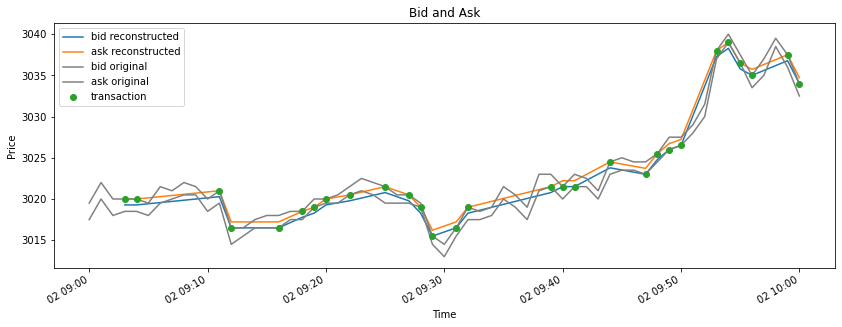

(20.124624676458552, 13.718843830885362)
(58.968093183802466, 55.12462467645855)
(134.30181149274344, 113.6751949830512)


In [206]:
klasyfikacjaPrzezRuchomekMeans(df_bid_ask_cut,df_selected_trans, df_selected_trans.loc[selection]['transaction'].std())

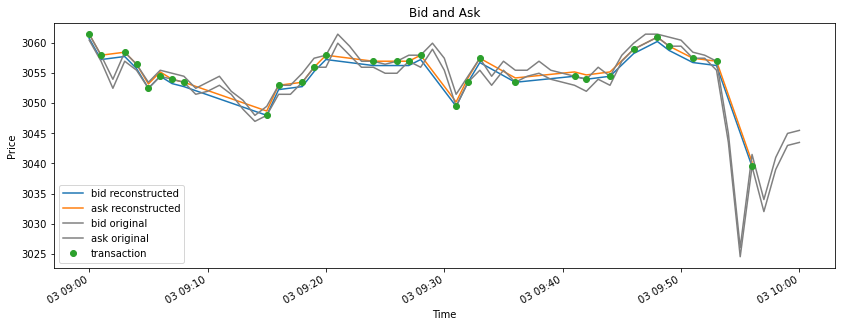

(20.062312338229276, 17.624624676458552)
(104.84346850734391, 105.87387402937566)
(616.6086749132708, 602.8660796212752)


In [207]:
klasyfikacjaPrzezRuchomekMeans(df_bid_ask_cut_test,df_selected_trans_test, df_selected_trans.loc[selection]['transaction'].std())